In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import pandas as pd
import pickle
import ccf_analysis_utils
import functions as func
import os

In [2]:
epoch = 'response'
r2_method = 'old_clipped'
epochs = ['sample', 'delay', 'response']
method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}
areas = ['Medulla','Midbrain', 'Striatum', 'Thalamus',]
df = pd.read_excel('mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx',engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

r2_new = pickle.load(open('r2_data_dict_timeshifts.pkl', 'rb'))

ccf_labels = r2_new['5_0']['ccf_labels'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
# center around bregma
ccf_coords[:,0] -= 5700
ccf_coords[:,2] -= 5400

is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]

In [3]:
figfolder = 'figs/subregions/striatum/'
os.makedirs(figfolder, exist_ok= True)

timeshifts = [-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16]
timeshifts = np.array(timeshifts)

In [4]:
Striatum_subregions = func.get_n_layer_down_subregions_from_name(df, 'Striatum', 1)['region'].values
Striatum_subregions_annotations = {}
for subregion in Striatum_subregions:
    Striatum_subregions_annotations[subregion] = func.get_all_subregion_annotations_from_name(df, subregion)['region'].values
inds = func.get_neuron_inds_for_subregions(ccf_labels, Striatum_subregions_annotations)

#filter for empty subregions
inds = {k: v for k, v in inds.items() if v.shape[0] > 0}
Striatum_subregions = [k for k, v in inds.items() if v.shape[0] > 0]

n_neurons = [v.shape[0] for v in inds.values()]

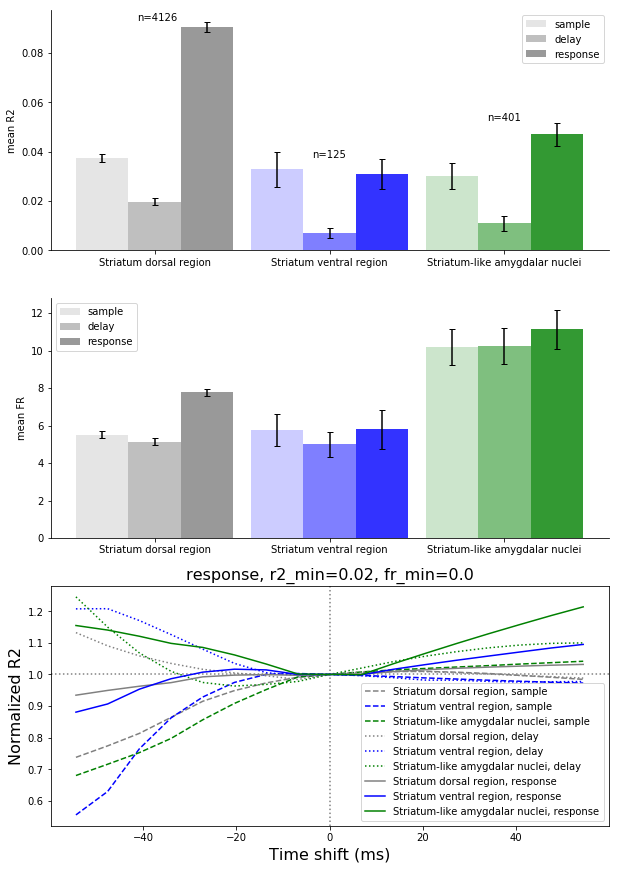

In [10]:
f = plt.figure(figsize=(10,15))
cc = ['grey','blue','green']
epoch_ls = ['dashed','dotted','solid']

ax_bar = f.add_subplot(3,1,1)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(r2, inds, Striatum_subregions)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 0.2 + iepoch*0.3, color = cc, 
                capsize = 3, width=0.3, label = epoch)
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, m[i] + sem[i] + 0.1 * max(sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(Striatum_subregions, rotation = 0)
_ = ax_bar.set_ylabel('mean R2')

ax_bar = f.add_subplot(3,1,2)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m_fr, sem_fr = func.get_mean_and_sem_for_subregions(fr, inds, Striatum_subregions)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m_fr, yerr = sem_fr, alpha = 0.2 + iepoch*0.3, color = cc, 
                capsize = 3, width=0.3, label = epoch)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(Striatum_subregions, rotation = 0)
_ = ax_bar.set_ylabel('mean FR')

ax_ts = f.add_subplot(3,1,3)

r2_threshold = .02
fr_threshold = 0.

for iepoch, epoch in enumerate(epochs):

    r2 = []

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2_old'%epoch].copy())

    r2= np.array(r2)
    r2[r2<0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[8,:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)



    ax_ts.set_title('%s, r2_min=%.2f, fr_min=%.1f'%(epoch,r2_threshold,fr_threshold), fontsize = 16)
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]

        this_inds = np.intersect1d(this_inds, threshold_inds)
        avg_r2 = r2[:,this_inds].mean(axis = 1)

        ax_ts.plot(timeshifts*3.4, avg_r2/avg_r2[8],color = cc[j], ls= epoch_ls[iepoch], label = area + ', ' + epoch)

a,b = ax_ts.set_xlim()
ax_ts.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
ax_ts.set_xlim(a,b)

a,b = ax_ts.set_ylim()
ax_ts.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
ax_ts.set_ylim(a,b)

ax_ts.set_xlabel('Time shift (ms)', fontsize = 16)
ax_ts.set_ylabel('Normalized R2', fontsize = 16)
ax_ts.legend()

#plt.savefig(figfolder + 'normalized_r2_timeshifts_r2_fr_threshold.png', dpi = 300)

plt.savefig(figfolder + 'striatum_subregions_1layer_fr_r2_%s.png'%epoch)

Here, we want to splot the dorsal region based on x coordinates, and not based on anatomical subnuclei.

In [15]:
medial_lateral_cutoff = 2500

In [16]:
dorsal_inds = {'Striatum dorsal region, medial': [], 'Striatum dorsal region, lateral': []}
for ii in inds['Striatum dorsal region']:
    ccf_x = ccf_coords[ii][0]
    if np.abs(ccf_x ) < medial_lateral_cutoff:
        dorsal_inds['Striatum dorsal region, medial'].append(ii)
    elif np.abs(ccf_x ) > medial_lateral_cutoff:
        dorsal_inds['Striatum dorsal region, lateral'].append(ii)

joint_inds = {}
for k in dorsal_inds.keys():
    joint_inds[k] = np.array(dorsal_inds[k])

for k in inds.keys():
    if k != 'Striatum dorsal region':
        joint_inds[k] = inds[k]

use_Striatum_nuclei = list(joint_inds.keys())

In [17]:
joint_color_list = ['grey', 'black', 'blue', 'green']
highlight_mask = [1,1,0,0]
neuron_count = [v.shape[0] for v in joint_inds.values()]

In [18]:
epoch = 'response'
r2_method = 'old_clipped'
r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

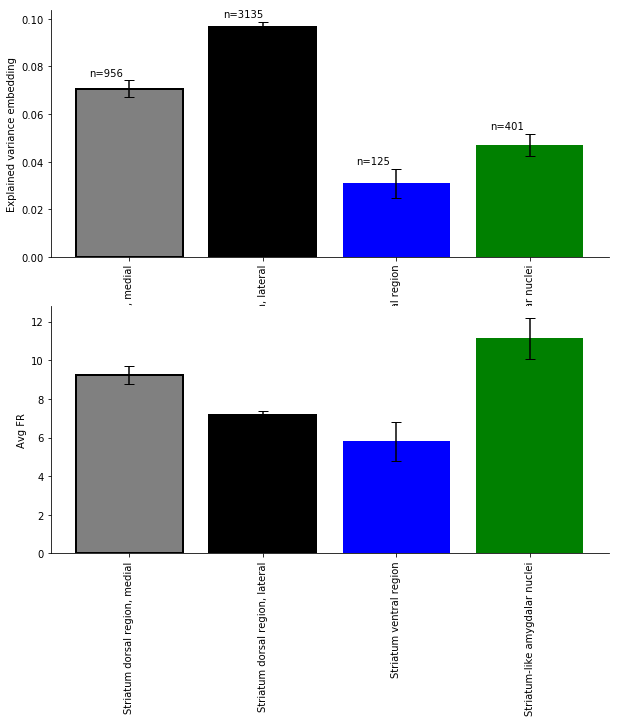

In [19]:
f = plt.figure(figsize=(10,10))
ax_bar = f.add_subplot(2,1,1)
m, sem = func.get_mean_and_sem_for_subregions(r2, joint_inds, use_Striatum_nuclei)
_ = func.plot_barplot_with_sem(ax_bar, m, sem, joint_color_list, use_Striatum_nuclei, 'Explained variance embedding', neuron_count, highlight_mask)


ax_bar = f.add_subplot(2,1,2)
m_fr, sem_fr = func.get_mean_and_sem_for_subregions(fr, joint_inds, use_Striatum_nuclei)
_ = func.plot_barplot_with_sem(ax_bar, m_fr, sem_fr, joint_color_list, use_Striatum_nuclei, 'Avg FR', highlight=highlight_mask)

plt.savefig(figfolder + 'striatum_subregions_%s_%s.pdf'%(epoch,r2_method), bbox_inches='tight')

In [20]:
plot_dict = dict()
plot_dict['xlim'] = (0, 6500)
plot_dict['ylim'] = (500,3500)
plot_dict['zlim'] = (500,3000)
plot_dict['axis_zero_label'] = 'ML'
plot_dict['axis_one_label'] = 'DV'
plot_dict['axis_two_label'] = 'AP'

colorlim = (0,0.3)

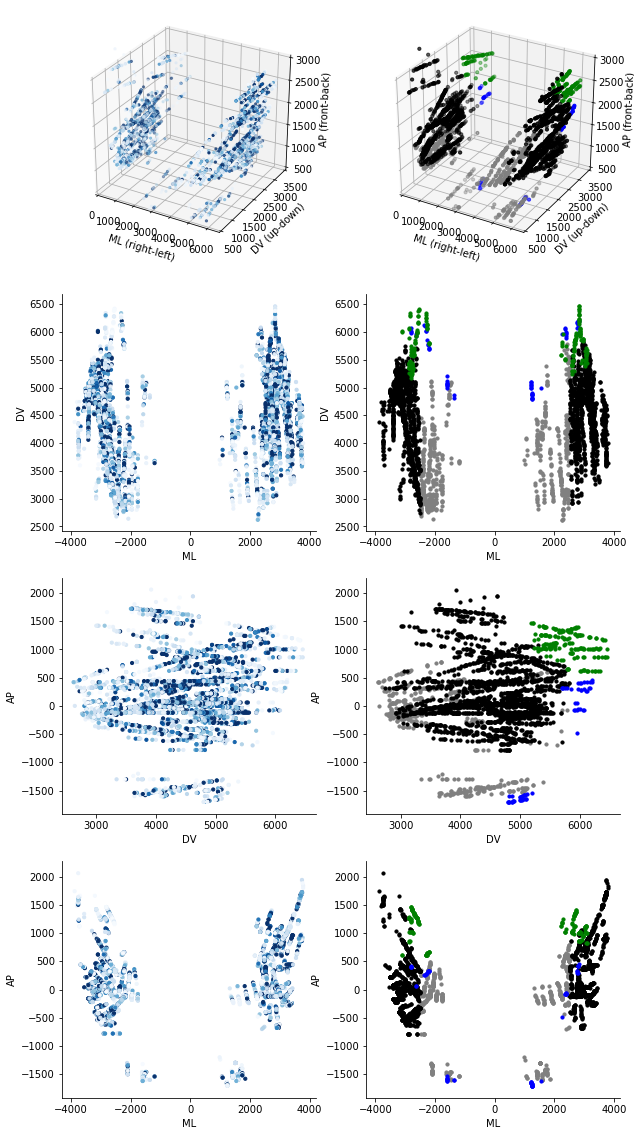

In [21]:
f = plt.figure(figsize=(10,20))
ax = f.add_subplot(4,2,1, projection='3d')
ccf_analysis_utils.add_color_map_plot(ax, use_Striatum_nuclei, joint_inds, r2, ccf_coords, \
                    0, (0.,0.2), True, plot_dict)

ax = f.add_subplot(4,2,2, projection='3d')
ccf_analysis_utils.add_solid_color_plot(ax, use_Striatum_nuclei, joint_inds, r2, \
                     ccf_coords, 0, \
                     joint_color_list, True, {**plot_dict})

ax = f.add_subplot(4,2,3)
three_d_flag = False
ccf_analysis_utils.add_color_map_plot(ax, use_Striatum_nuclei, joint_inds, r2, ccf_coords[:,0:2], \
                    0, (0.,0.2), three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV'})

ax = f.add_subplot(4,2,4)
ccf_analysis_utils.add_solid_color_plot(ax, use_Striatum_nuclei, joint_inds, r2, \
                        ccf_coords[:,0:2], 0, \
                        joint_color_list, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV'})

ax = f.add_subplot(4,2,5)
ccf_analysis_utils.add_color_map_plot(ax, use_Striatum_nuclei, joint_inds, r2, ccf_coords[:,1:], \
                    0, (0.,0.2), three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP'})

ax = f.add_subplot(4,2,6)
ccf_analysis_utils.add_solid_color_plot(ax, use_Striatum_nuclei, joint_inds, r2, \
                     ccf_coords[:,1:], 0, \
                     joint_color_list, three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP'})

ax = f.add_subplot(4,2,7)
ccf_analysis_utils.add_color_map_plot(ax, use_Striatum_nuclei, joint_inds, r2, ccf_coords[:,0::2], \
                    0, (0.,0.2), three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP'})

ax = f.add_subplot(4,2,8)
ccf_analysis_utils.add_solid_color_plot(ax, use_Striatum_nuclei, joint_inds, r2, \
                     ccf_coords[:,0::2], 0, \
                     joint_color_list, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP'})

plt.savefig(figfolder + 'striatum_subregions_spatial_maps_%s_%s.pdf'%(epoch,r2_method), bbox_inches='tight')